In [1]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys

In [2]:
# reading the arguments
# instructions on giving the arguments are in the ReadME.txt file
temp, env_name, rtg, anf, N, K = sys.argv
# temp, env_name, rtg, anf, N, K = ['Q3.ipynb','lunarlander','True','False','150','50']

In [3]:
if(env_name=='cartpole'):
    env = gym.make('CartPole-v0')
    acs = 2
    obs = 4
elif(env_name=='lunarlander'):
    env = gym.make('LunarLander-v2')
    acs = 4
    obs = 8
else:
    print("Wrong Input")

/home/raktim/anaconda3/envs/raktim/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# printing the state space and action space as asked in part (a) of the question
print("State Space: ",env.observation_space)
print("Action Space: ",env.action_space)

State Space:  Box(8,)
Action Space:  Discrete(4)


In [5]:
state = env.reset()
state = state[None,:]

In [6]:
# defining the loss function
def PGLoss(T,A):
    tot = np.zeros([len(T),T[0][0].shape[0]])
    for i in range(0,len(T)):
        for j in range(0,len(T[i])):
            tot[i]+=(T[i][j])*A[i][j]
    lss = np.mean(tot)
    return lss

In [7]:
# function to calculate reward to go
def reward_to_go(x,gamma):
    At = []
    for i in range(0,len(x)):
        Gt = []
        for j in range(0,len(x[i])):
            tot = 0
            for k in range(j,len(x[i])):
                tot+=gamma**(k-j)*x[i][k]
            Gt.append(tot)
        At.append(Gt)
    return At

In [8]:
# function to calculate si function without reward to go
def tot_reward(x,gamma):
    At = []
    for i in range(0,len(x)):
        Gt = []
        for j in range(0,len(x[i])):
            tot = 0
            for k in range(0,len(x[i])):
                tot+=gamma**k*x[i][k]
            Gt.append(tot)
        At.append(Gt)
    return At

In [9]:
# fucntion to calculate advantage normalisation. Mean is used as baseline
def adv_norm(x):
    t = [a for m in x for a in m]
    b = sum(t)/len(t)
    var = sum([((a - b) ** 2) for a in t]) / len(t)
    for i in range(len(x)):
        for j in range(len(x[i])):
            x[i][j] = (x[i][j] - b) #/var
    return x

In [10]:
def softmax(x):
    x1 = np.exp(x)
    out = x1/np.sum(x1)
    return out

In [11]:
def softmax_gradient(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

In [12]:
# defining the logistic regression model
def model(state):
    z = state@W
    out = softmax(z)
    return out

In [13]:
# updating the parameters of the model
def update_params(traj,A,st,AC,W):
    G = 0
    for i in range(len(traj)):
        for j in range(len(traj[i])):
            sgrad = softmax_gradient(np.array(traj[i][j]))[AC[i][j],:]
            temp = sgrad/traj[i][j][AC[i][j]]
            grad = st[i][j].T@temp[None,:]
            grad = grad*A[i][j]      # gradient calculation
            G += grad
    G = G/len(traj)
    W = W + lr*G
    return W

In [14]:
lr = 0.01   # learning rate
gamma = 0.99  # value of gamma
W = np.random.rand(obs,acs)  # initialising the weights
res = []
for i in range(0,int(N)):
    R = []
    traj = []
    st = []
    AC = []
    RE = []
    t = 0
    for k in range(0,int(K)):
        state = env.reset()
        state = state[None,:]
        done = False
        r = []
        temp = []
        s = []
        a = []
        re = 0
        while(done!=True):
            pie = model(state)
            s.append(state)
            action = np.random.choice(acs,p=pie[0])
            state, reward, done,_ = env.step(action)   # taking step in the action and storing reward
            state = state[None,:]
            r.append(reward)
            temp.append(pie[0])
            a.append(action)
            re+=reward
            if(done==True):
                traj.append(temp)
                R.append(r)
                st.append(s)
                AC.append(a)
                RE.append(re)
                t = 1
    if(rtg==str(True)):    # Reward to go
        A = reward_to_go(R,gamma)
    elif(anf==str(True)):  # Advantage normalisation
        A = reward_to_go(R,gamma)
        A = adv_norm(A)
    else:
        A = tot_reward(R,gamma)
    W = update_params(traj,A,st,AC,W)
    res.append(sum(RE)/len(RE))
    print("Epoch:",i,"; Avg.reward:",sum(RE)/len(RE),"; Max Reward in Epoch:",max(RE),"; Min Reward in Epoch",min(RE))

Epoch: 0 ; Avg.reward: -219.7769591970213 ; Max Reward in Epoch: -5.48993612893932 ; Min Reward in Epoch -525.7952178538742
Epoch: 1 ; Avg.reward: -543.7044847699126 ; Max Reward in Epoch: -330.04187324777104 ; Min Reward in Epoch -1118.457206562815
Epoch: 2 ; Avg.reward: -345.613625782525 ; Max Reward in Epoch: -191.0753640329906 ; Min Reward in Epoch -468.98739324152274
Epoch: 3 ; Avg.reward: -316.887538778312 ; Max Reward in Epoch: -142.52999558492075 ; Min Reward in Epoch -546.1005266751682
Epoch: 4 ; Avg.reward: -133.73712473212984 ; Max Reward in Epoch: 45.79303204228137 ; Min Reward in Epoch -217.72871496970816
Epoch: 5 ; Avg.reward: -150.433431648338 ; Max Reward in Epoch: 12.178095513677562 ; Min Reward in Epoch -251.5523083726612
Epoch: 6 ; Avg.reward: -132.6530991259288 ; Max Reward in Epoch: -70.44451238397922 ; Min Reward in Epoch -211.69367321569575
Epoch: 7 ; Avg.reward: -141.91605004229038 ; Max Reward in Epoch: -67.19599851081524 ; Min Reward in Epoch -225.990563240962

Epoch: 66 ; Avg.reward: -119.07251132257937 ; Max Reward in Epoch: -82.05117796789759 ; Min Reward in Epoch -158.93459091042962
Epoch: 67 ; Avg.reward: -117.26958187017227 ; Max Reward in Epoch: -86.00513849605889 ; Min Reward in Epoch -142.4902382526483
Epoch: 68 ; Avg.reward: -131.38215806061112 ; Max Reward in Epoch: -3.939912678909451 ; Min Reward in Epoch -160.86786620504307
Epoch: 69 ; Avg.reward: -124.93291633801526 ; Max Reward in Epoch: 4.512020767794695 ; Min Reward in Epoch -162.7576948331279
Epoch: 70 ; Avg.reward: -134.93554518753223 ; Max Reward in Epoch: -38.04855285347632 ; Min Reward in Epoch -175.84293574656948
Epoch: 71 ; Avg.reward: -152.13878231005896 ; Max Reward in Epoch: 14.553347749576417 ; Min Reward in Epoch -201.81942436840046
Epoch: 72 ; Avg.reward: -138.81112744334132 ; Max Reward in Epoch: 28.289877576863177 ; Min Reward in Epoch -224.81250948796873
Epoch: 73 ; Avg.reward: -151.84988810759626 ; Max Reward in Epoch: -35.42473563260623 ; Min Reward in Epoch

Epoch: 131 ; Avg.reward: 198.39297994764232 ; Max Reward in Epoch: 297.9016392836006 ; Min Reward in Epoch -99.1662540872266
Epoch: 132 ; Avg.reward: 195.33274377512495 ; Max Reward in Epoch: 308.92087185151985 ; Min Reward in Epoch -30.43983605225972
Epoch: 133 ; Avg.reward: 193.90323706703333 ; Max Reward in Epoch: 311.3771041817834 ; Min Reward in Epoch -136.27484467237818
Epoch: 134 ; Avg.reward: 202.50788830992573 ; Max Reward in Epoch: 304.37008760632034 ; Min Reward in Epoch -133.70299656460182
Epoch: 135 ; Avg.reward: 182.07657916682976 ; Max Reward in Epoch: 315.2423810254055 ; Min Reward in Epoch -164.912102480548
Epoch: 136 ; Avg.reward: 200.38137967644153 ; Max Reward in Epoch: 297.45145908203415 ; Min Reward in Epoch -144.32622659413985
Epoch: 137 ; Avg.reward: 152.66398405336417 ; Max Reward in Epoch: 305.3281215741413 ; Min Reward in Epoch -142.2037978770021
Epoch: 138 ; Avg.reward: 155.28211374747792 ; Max Reward in Epoch: 310.52901775073195 ; Min Reward in Epoch -49.85

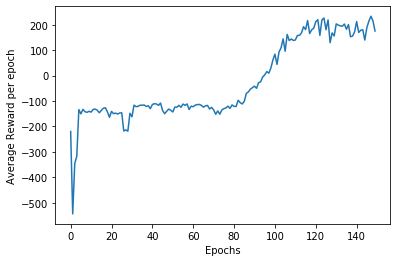

In [15]:
# plotting the preformance
plt.plot(res)
plt.xlabel("Epochs")
plt.ylabel("Average Reward per epoch")
plt.show()

In [20]:
# Uncomment the following lines to render the environment after training and see the trained model

# state = env.reset()
# state = state[None,:]
# done = False
# while(done!=True):
#     env.render()
#     pie = model(state)
#     action = np.random.choice(acs,p=pie[0])
#     state, reward, done, _ = env.step(action)
#     state = state[None,:]